In [1]:
import os
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import torch
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

In [2]:
torch.cuda.empty_cache()

In [3]:
plt.rcParams["figure.figsize"] = (27, 9)

In [4]:
bc_dict = {0: ['WBC', 'y'], 1: ['RBC', 'r'], 2: ['Platelets', 'b']}

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class BloodCellDataset(torch.utils.data.Dataset):
    def __init__(self, directory, transformers=None):
        self.directory = directory
        self.transformers = transformers
        self.images = list(sorted(os.listdir(os.path.join(self.directory + '\\images'))))
        self.labels = list(sorted(os.listdir(os.path.join(self.directory + '\\labels'))))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.directory + '\\images', self.images[idx])
        img = Image.open(image_path)
        img_tensor = T.ToTensor()(img)
        label_path = os.path.join(self.directory + '\\labels', self.labels[idx])
        boxes = torch.from_numpy(np.loadtxt(label_path, usecols=(1, 2, 3, 4)))
        if boxes.shape == (4,):
            boxes = torch.unsqueeze(boxes, 0)
        ### initially bbox coordinates have format (xcenter, ycenter, width, height)
        ### transform it to (xmin, ymin, xmax, ymax) and scale by multiplying on image size (416x416)
        boxes[:, 0] = boxes[:, 0] - boxes[:, 2] / 2
        boxes[:, 1] = boxes[:, 1] - boxes[:, 3] / 2
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes[:, :] = boxes[:, :] * img_tensor.shape[1]
        label = torch.from_numpy(np.loadtxt(label_path, usecols=(0), dtype=np.int64))
        if label.shape == torch.Size([]):
            label = torch.unsqueeze(label, 0)
        targets = {}
        targets['boxes'] = boxes
        targets['labels'] = label
        return img_tensor, targets

In [7]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [8]:
def show_img_box_label(img, targ, thickness=1):
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    for i in range(len(targ['boxes'])):
        label = bc_dict[targ['labels'][i].item()][0]
        ecolor = bc_dict[targ['labels'][i].item()][1]
        x, y, xmax, ymax = targ['boxes'][i]
        plt.gca().add_patch(Rectangle((x, y), xmax-x, ymax-y, linewidth=thickness, edgecolor=ecolor, facecolor='none'))
        plt.annotate(label, (x, y), color='black', weight='bold', fontsize=8)

In [9]:
train_data = BloodCellDataset(os.getcwd() + '\\train')
val_data = BloodCellDataset(os.getcwd() + '\\valid')
train_data = train_data + val_data

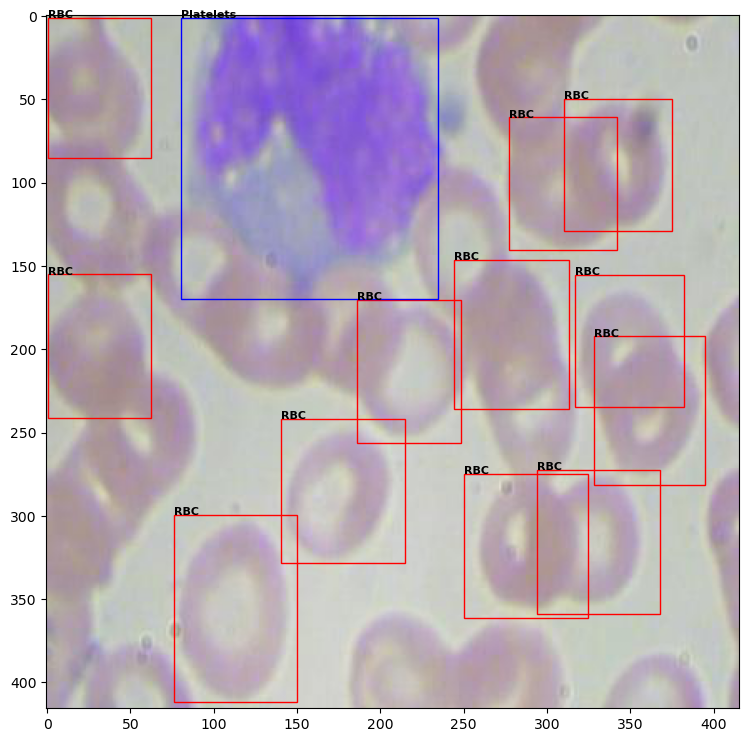

In [10]:
show_img_box_label(train_data[821][0], train_data[821][1])

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=False, collate_fn=collate_fn)

In [13]:
images, targets = next(iter(train_dataloader))

In [14]:
def show_batch(images, targets):
    cells = [draw_bounding_boxes(image_int, boxes=target['boxes'], labels=[bc_dict[int(i)][0] for i in target['labels']],
                                 width=1, colors='black') for image_int,
             target in zip([(image * 255).type(dtype=torch.uint8) for image in list(images)], list(targets))]
    show(cells)

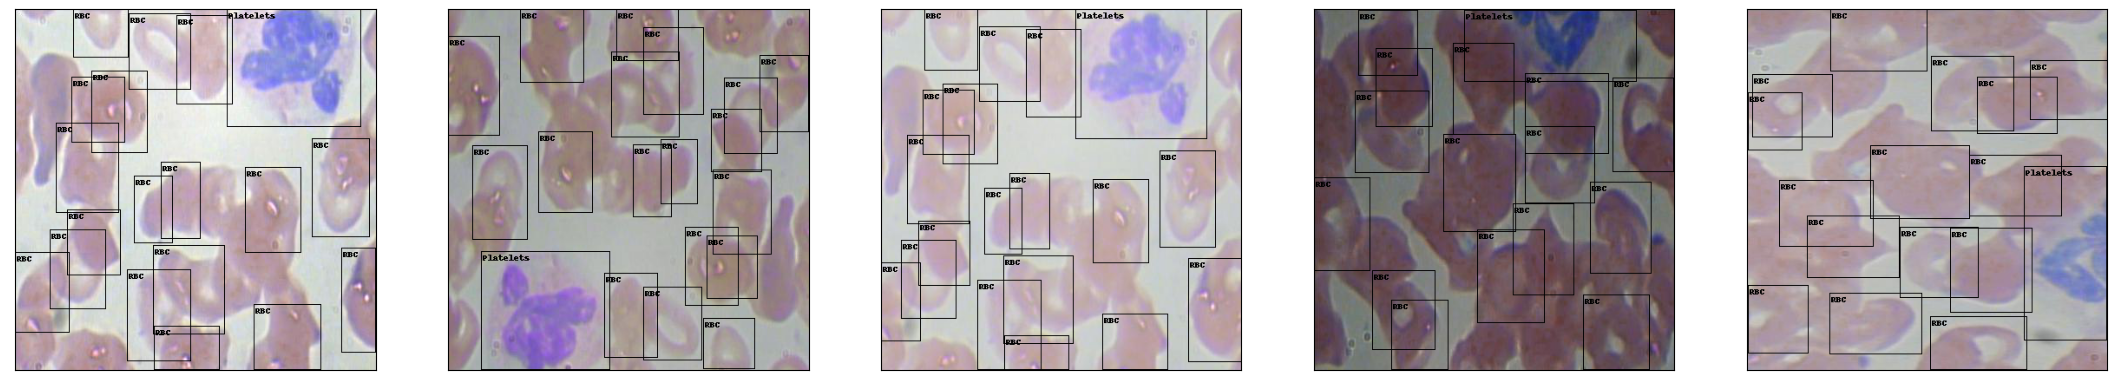

In [15]:
show_batch(images, targets)

In [16]:
model = models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')

In [17]:
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [18]:
model = model.to(device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
def train_model(model, train_dataloader, optimizer, scheduler, n_epochs):
    
    train_loss = []
           
    for epoch in range(n_epochs):
        ep_train_loss = []
        
        model.train()
        
        for images, targets in tqdm(train_dataloader):
            images_input = list(image.to(device) for image in images)
            targets_input = [{k: v.to(device) for k, v in t.items()} for t in targets]
            try:
                output = model(images_input, targets_input)
                losses = sum(loss for loss in output.values())
                losses.backward()
                optimizer.step()
                optimizer.zero_grad()
                ep_train_loss.append(losses.item())
            except:
                'AssertionError'
                
        print(f'Epoch {epoch + 1} of {n_epochs}')
        
        scheduler.step()
        
        train_loss.append(np.mean(ep_train_loss))
        
        print(f"\t training loss: {train_loss[-1]:.6f}")
        
    return train_loss

In [21]:
%%time
train_loss = train_model(model, train_dataloader, optimizer, scheduler, 20)

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:20<00:00,  2.10it/s]


Epoch 1 of 20
	 training loss: 1.633639


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.41it/s]


Epoch 2 of 20
	 training loss: 1.132704


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:10<00:00,  2.40it/s]


Epoch 3 of 20
	 training loss: 0.973882


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.40it/s]


Epoch 4 of 20
	 training loss: 0.808096


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:10<00:00,  2.40it/s]


Epoch 5 of 20
	 training loss: 0.708483


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.40it/s]


Epoch 6 of 20
	 training loss: 0.653408


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:10<00:00,  2.40it/s]


Epoch 7 of 20
	 training loss: 0.615038


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.41it/s]


Epoch 8 of 20
	 training loss: 0.547568


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.41it/s]


Epoch 9 of 20
	 training loss: 0.529845


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.41it/s]


Epoch 10 of 20
	 training loss: 0.519716


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.41it/s]


Epoch 11 of 20
	 training loss: 0.510848


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.41it/s]


Epoch 12 of 20
	 training loss: 0.501025


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.41it/s]


Epoch 13 of 20
	 training loss: 0.493933


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.41it/s]


Epoch 14 of 20
	 training loss: 0.487799


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:10<00:00,  2.40it/s]


Epoch 15 of 20
	 training loss: 0.490615


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.41it/s]


Epoch 16 of 20
	 training loss: 0.482675


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.41it/s]


Epoch 17 of 20
	 training loss: 0.481151


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.41it/s]


Epoch 18 of 20
	 training loss: 0.479501


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.41it/s]


Epoch 19 of 20
	 training loss: 0.475942


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:09<00:00,  2.40it/s]

Epoch 20 of 20
	 training loss: 0.475127
CPU times: total: 1h 22min 28s
Wall time: 23min 27s


In [37]:
def plot_train_process(train_loss):
    fig, axes = plt.subplots()
    axes.set_title('Loss')
    axes.plot(train_loss, label = 'train')
    axes.legend()

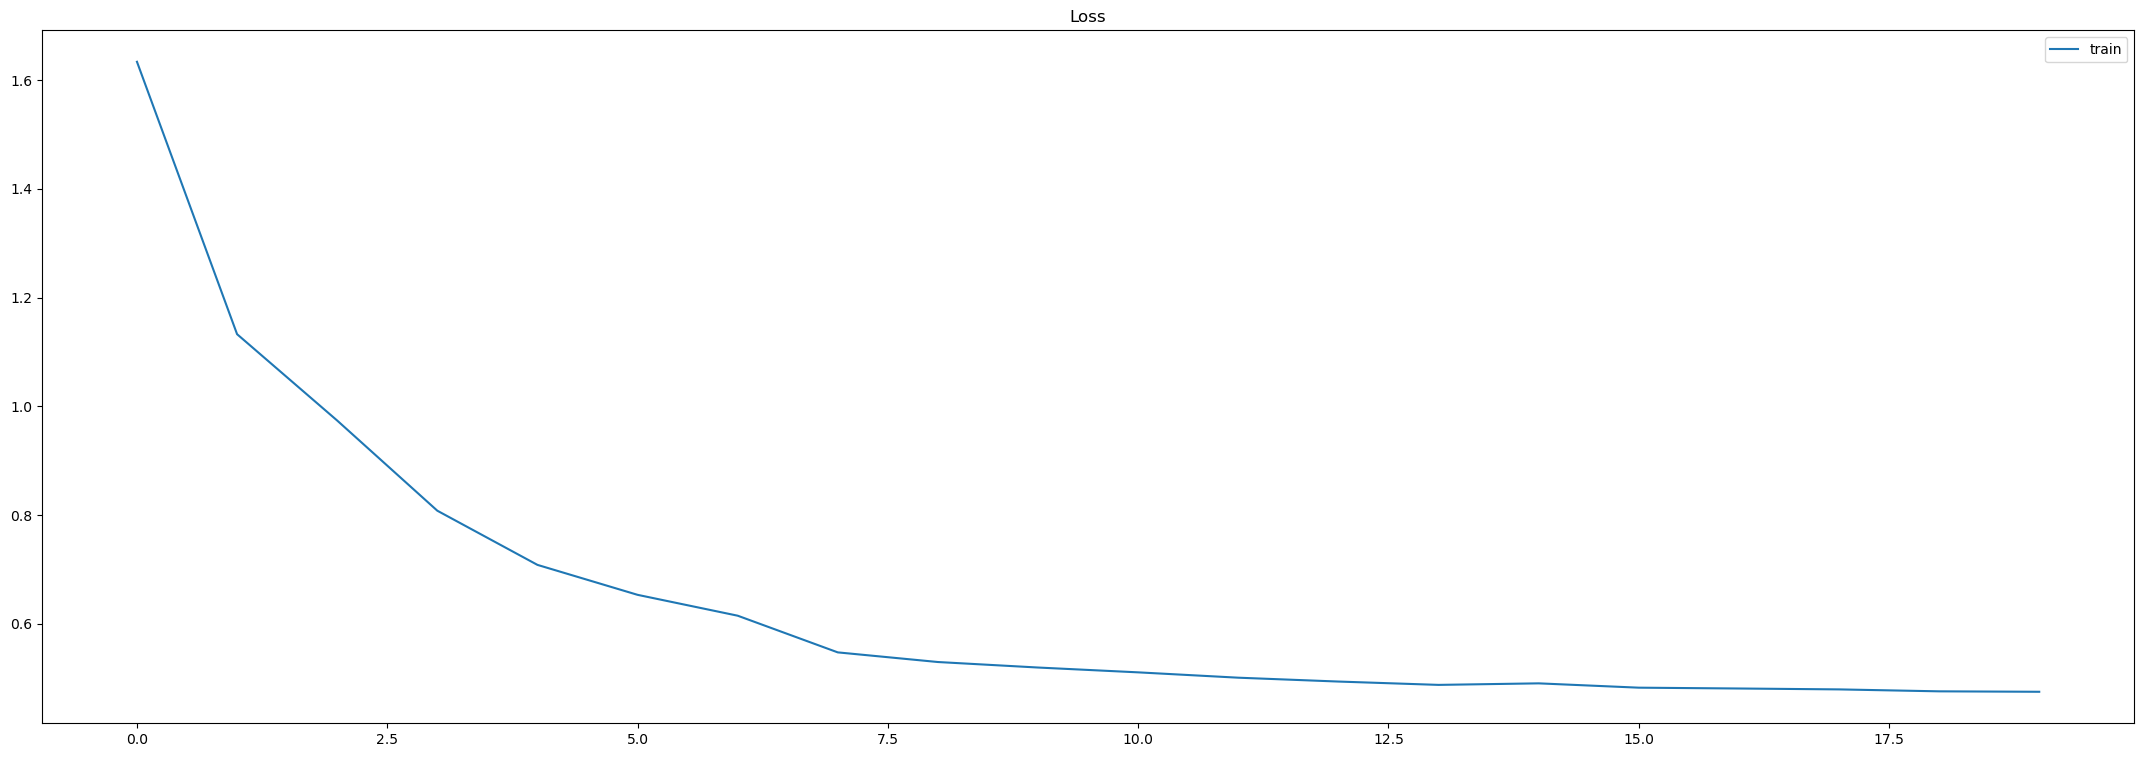

In [38]:
plot_train_process(train_loss)

In [22]:
torch.save(model.state_dict(), os.getcwd() + '\\BCFasterRCNN.pth')

In [23]:
test_data = BloodCellDataset(os.getcwd() + '\\test')

In [24]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

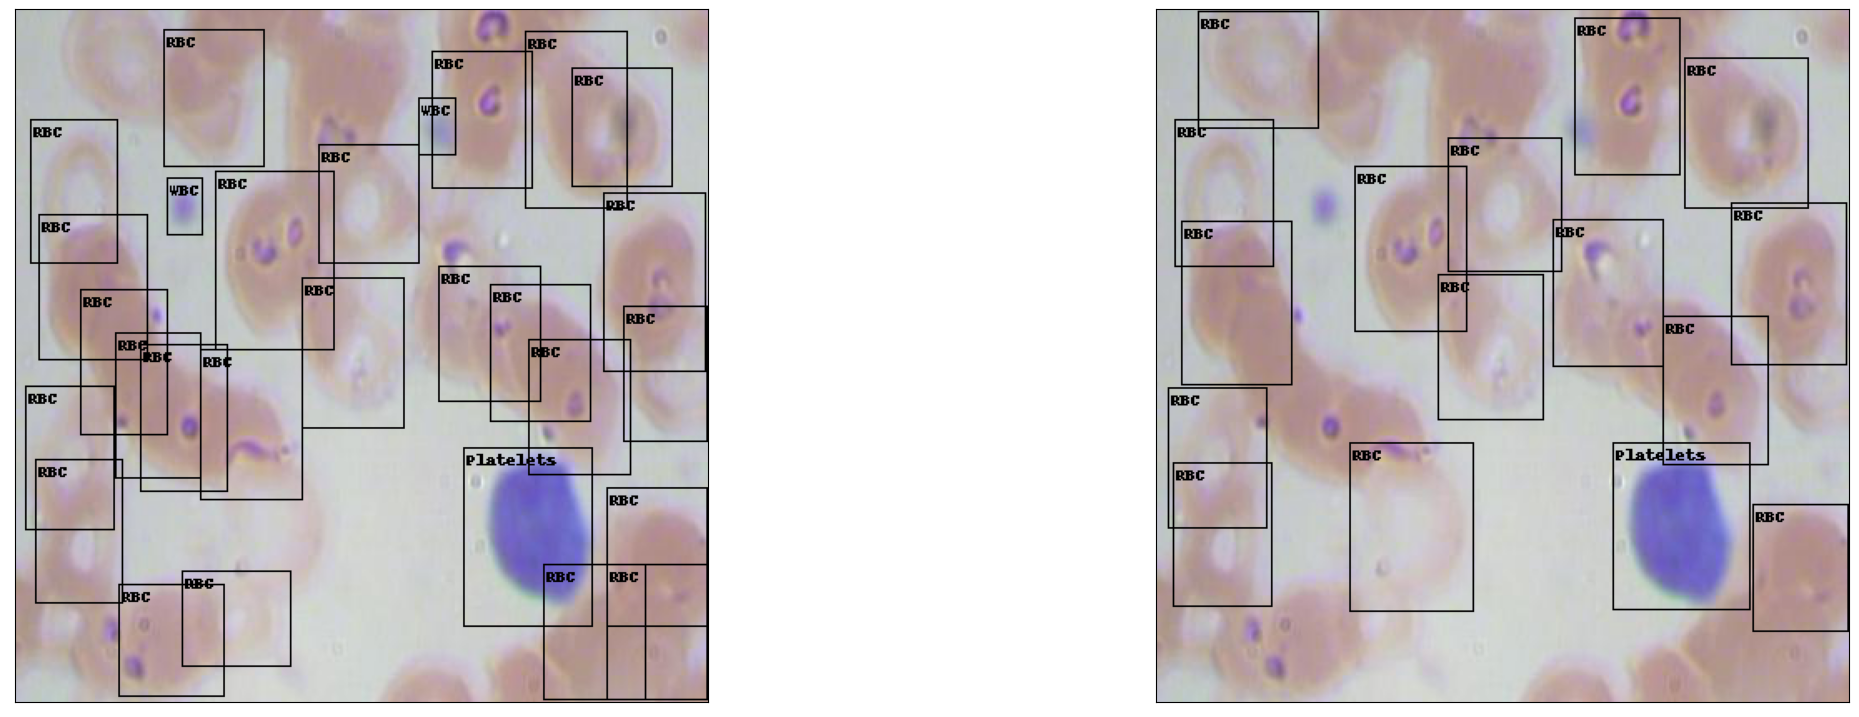

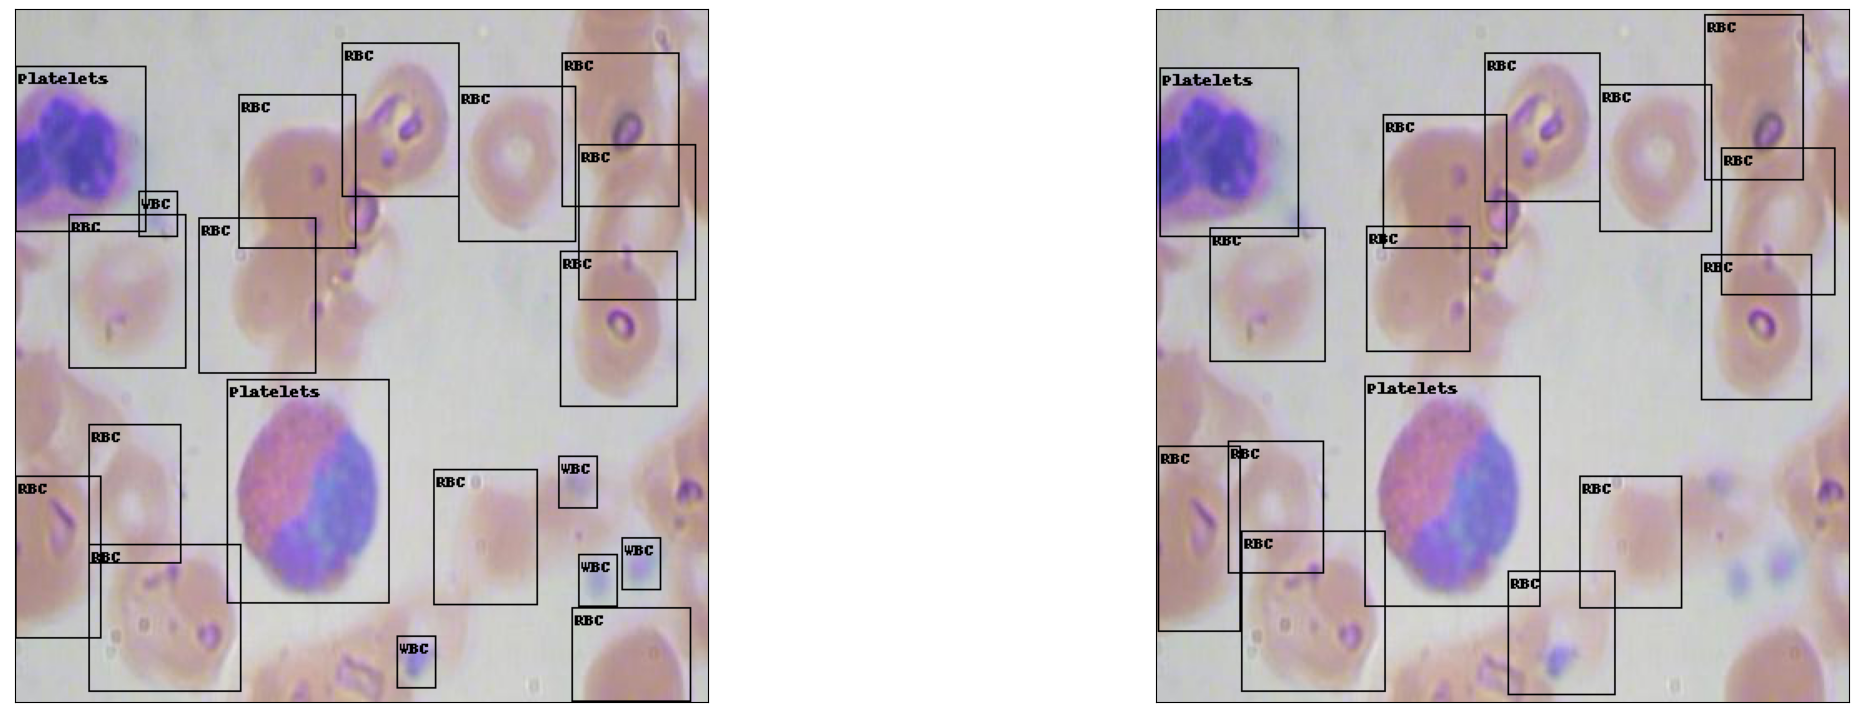

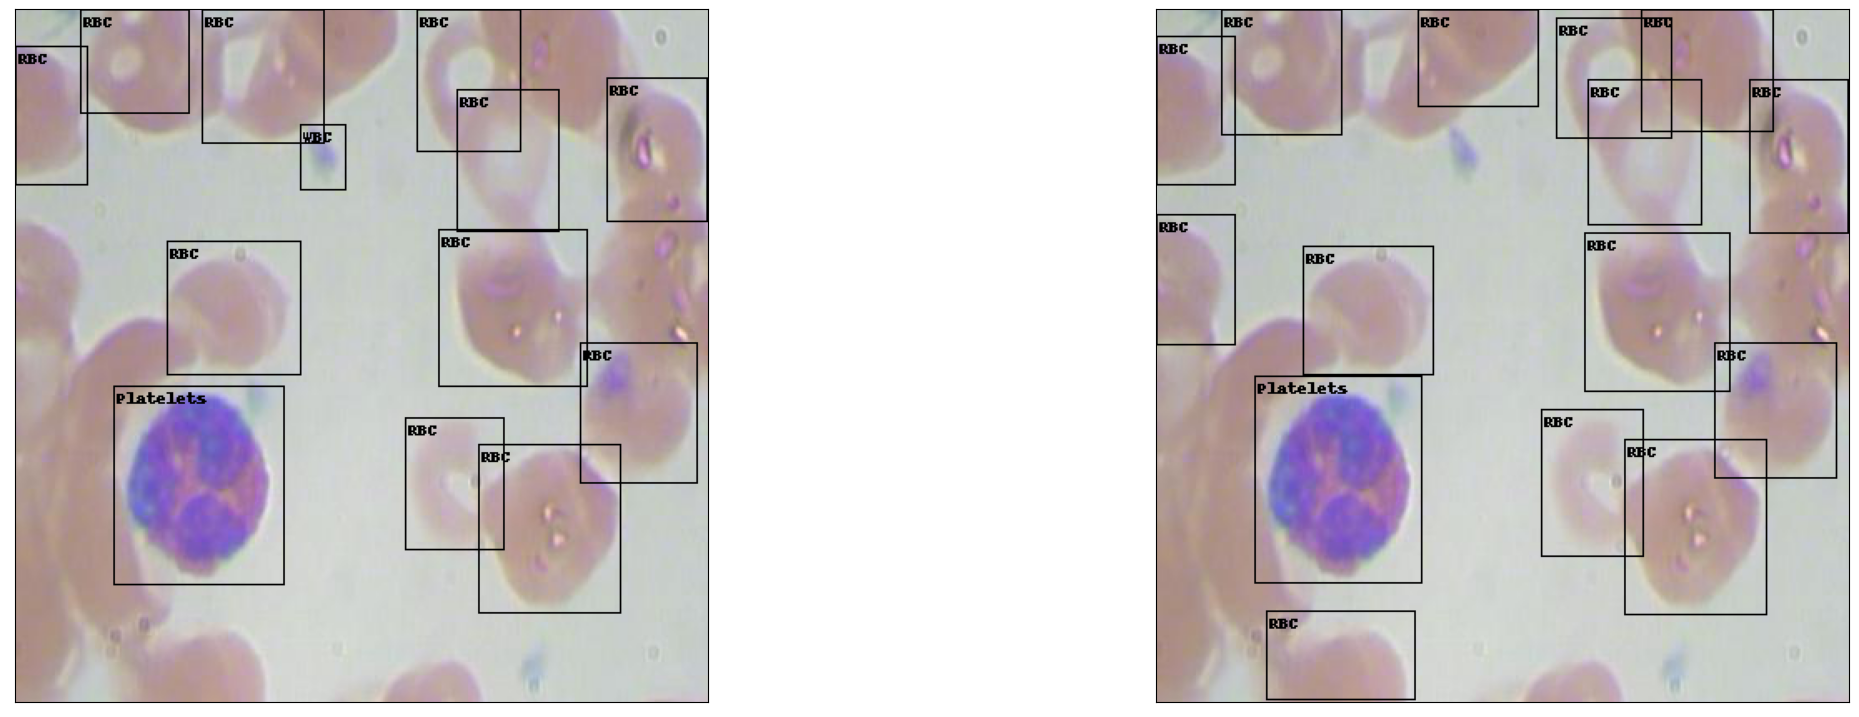

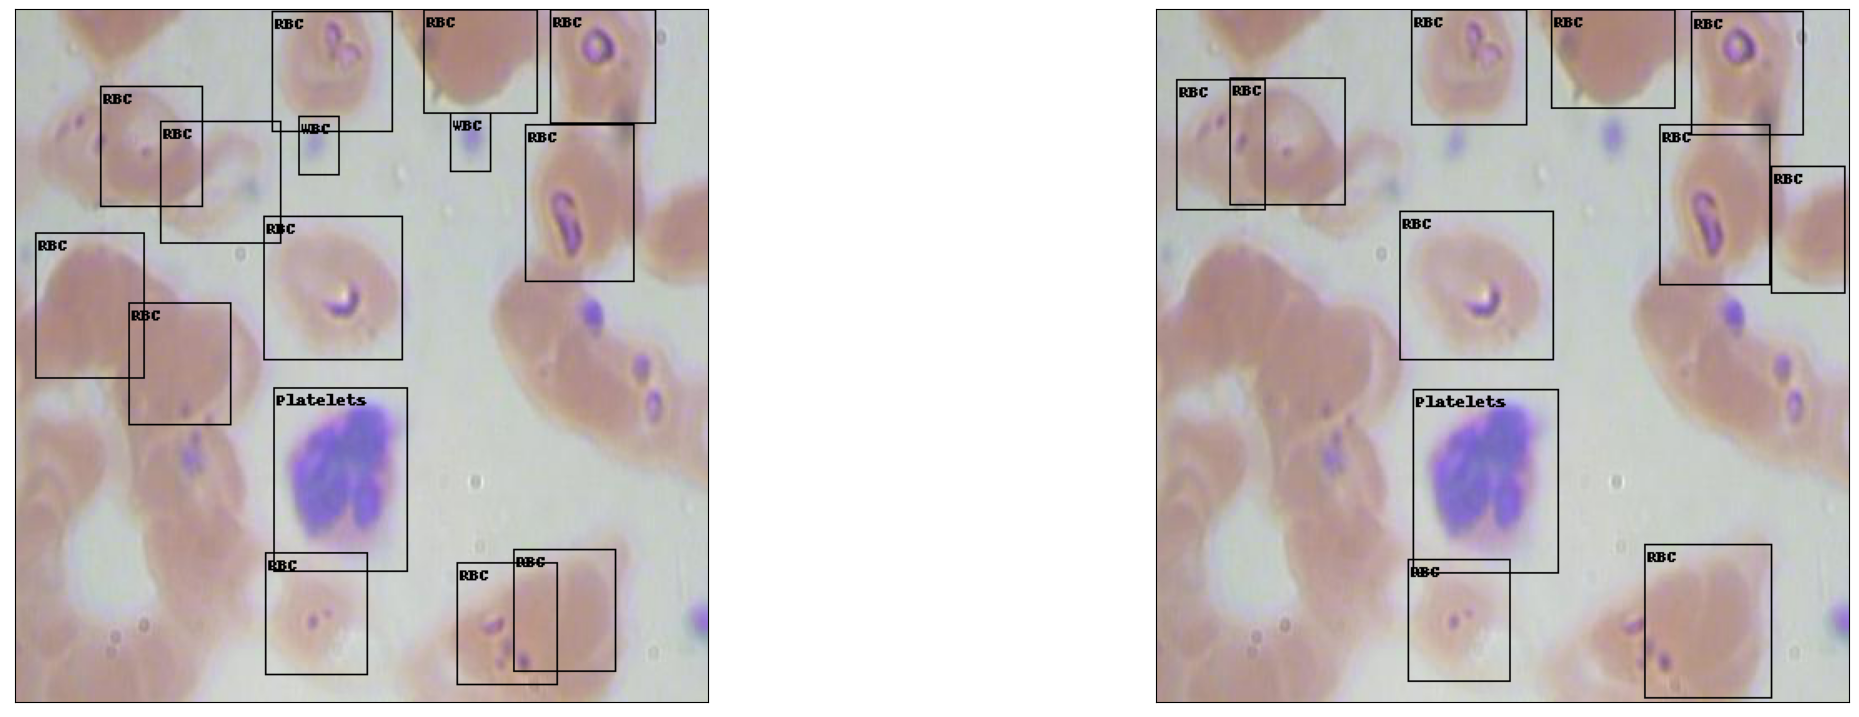

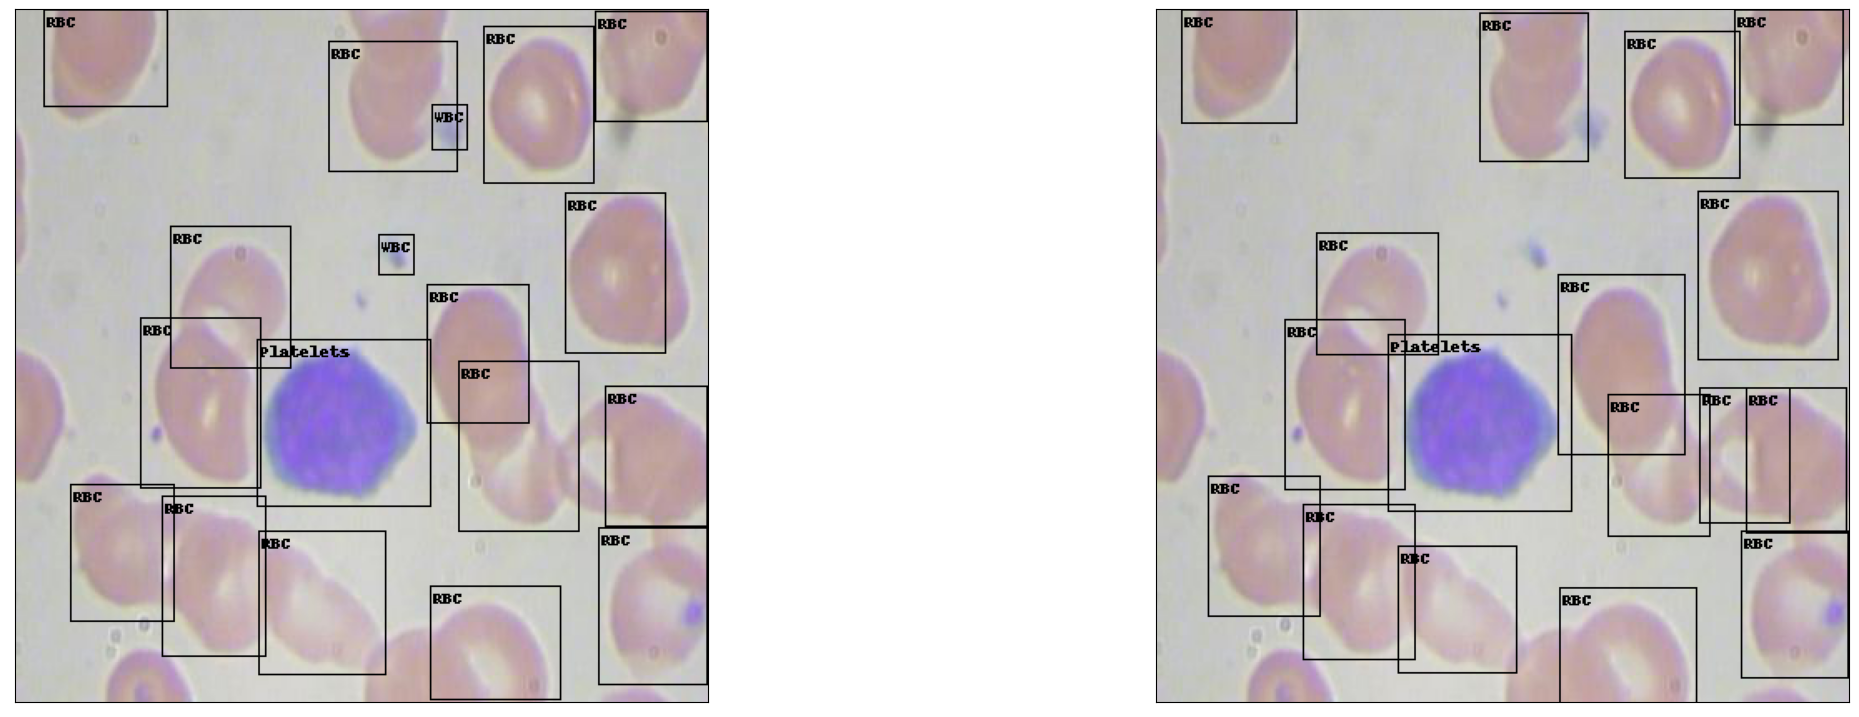

In [27]:
for i in range(len(test_data)):
    if i == 5:
        break
    predictions = model([test_data[i][0].to(device)])
    output = {}
    output['boxes'] = [pred['boxes'][pred['scores'] > 0.5] for pred in predictions][0]
    output['labels'] = [pred['labels'][pred['scores'] > 0.5] for pred in predictions][0]
    show_batch((test_data[i][0], test_data[i][0]), (test_data[i][1], output))